Import Library

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
from pathlib import Path

Access Data

In [261]:
train_path = Path("car_data/data/training_images")
test_path = Path("car_data/data/testing_images")

In [262]:
train = pd.read_csv("car_data/data/train_solution_bounding_boxes (1).csv")
print(train.columns)

train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Index(['image', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


Kolom xmin, ymin, xmax, dan ymax dikonversi ke tipe integer, dan gambar yang duplikat dihapus dari dataset.

In [263]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])
        

Fungsi-fungsi ini digunakan untuk menampilkan gambar dengan bounding box, menampilkan gambar dengan bounding box yang ditentukan, dan membaca gambar dari file dan menampilkan gambar dari baris dataframe masing-masing

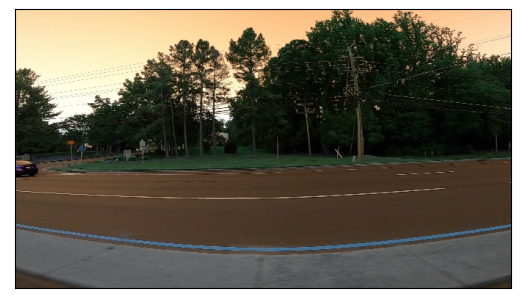

In [264]:
display_image_from_file("vid_4_10520.jpg")

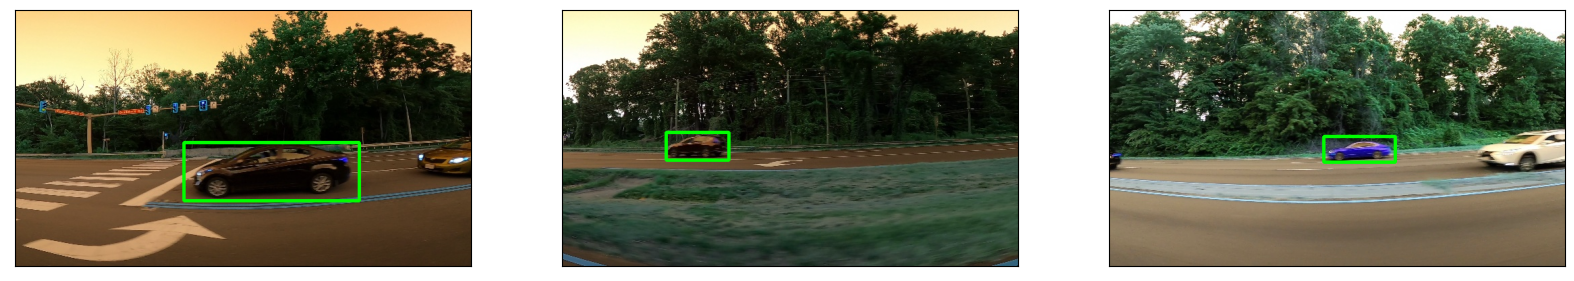

In [265]:
display_grid()

Bagian ini menampilkan beberapa gambar secara acak dari dataset dalam format grid

In [266]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}
        

Bagian ini menampilkan beberapa gambar secara acak dari dataset dalam format grid

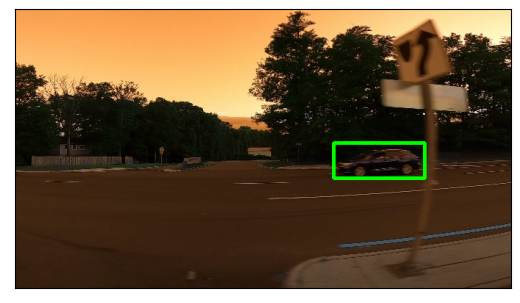

In [267]:
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)


menguji generator data dengan menghasilkan satu batch dan menampilkan gambar dengan bounding box.

In [268]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d_80 (Conv2D)          (None, 380, 676, 8)       224       
                                                                 
 batch_normalization_80 (Bat  (None, 380, 676, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 190, 338, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_81 (Bat  (None, 190, 338, 16)     64  

Bagian ini mendefinisikan arsitektur model CNN. Model memiliki 10 lapisan Conv2D dengan BatchNormalization dan MaxPooling, diikuti oleh lapisan Dense untuk prediksi koordinat bounding box

In [273]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [274]:
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

Fungsi-fungsi untuk menguji model dengan menampilkan gambar dan bounding box yang diprediksi oleh model serta Callback yang digunakan untuk menampilkan gambar hasil prediksi model pada akhir setiap epoch

Epoch 1/9
1/1 [==============================] - 0s 88ms/step


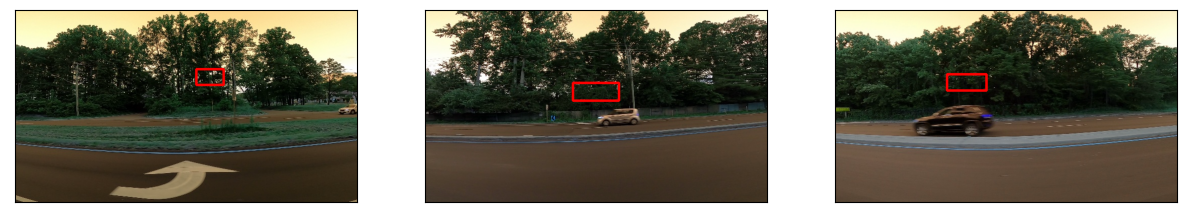

500/500 [==============================] - 2373s 5s/step - loss: 3758.6050 - accuracy: 0.8823
Epoch 2/9
1/1 [==============================] - 0s 113ms/step


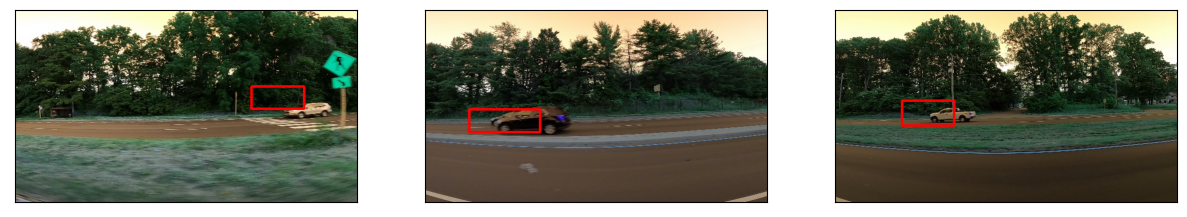

500/500 [==============================] - 2415s 5s/step - loss: 731.4944 - accuracy: 0.9688
Epoch 3/9
1/1 [==============================] - 0s 113ms/step


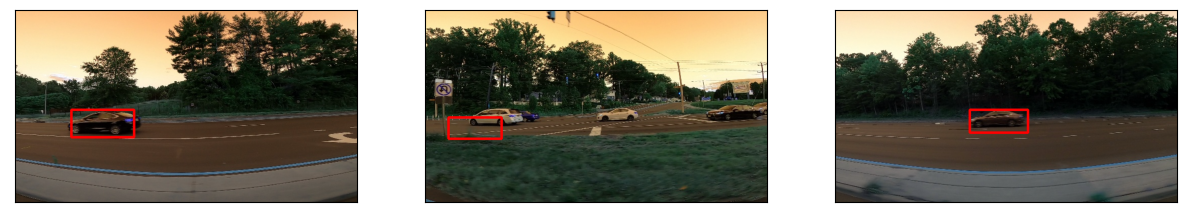

500/500 [==============================] - 2360s 5s/step - loss: 1267.8330 - accuracy: 0.9563
Epoch 4/9
1/1 [==============================] - 0s 123ms/step


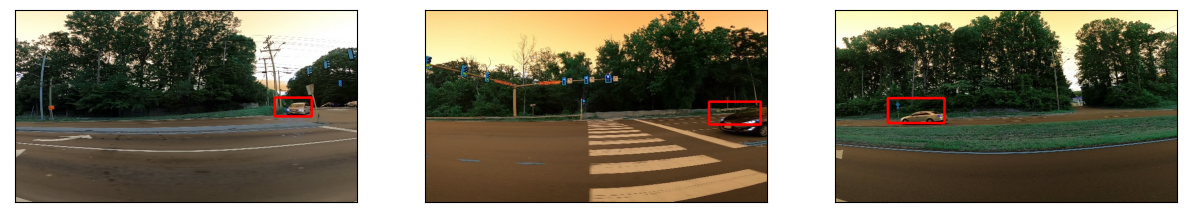

500/500 [==============================] - 2316s 5s/step - loss: 309.2903 - accuracy: 0.9812
Epoch 5/9
1/1 [==============================] - 0s 66ms/step


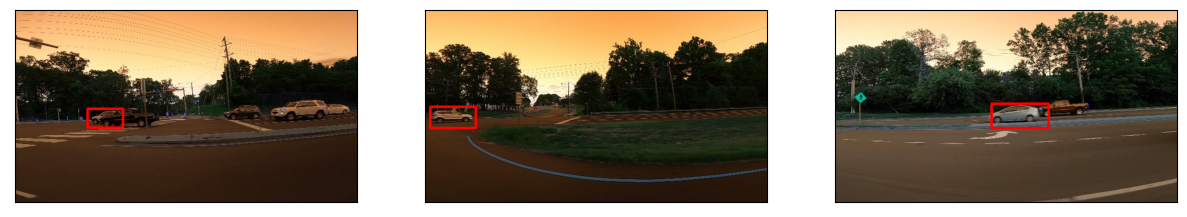

500/500 [==============================] - 2310s 5s/step - loss: 148.1230 - accuracy: 0.9864
Epoch 6/9
1/1 [==============================] - 0s 67ms/step


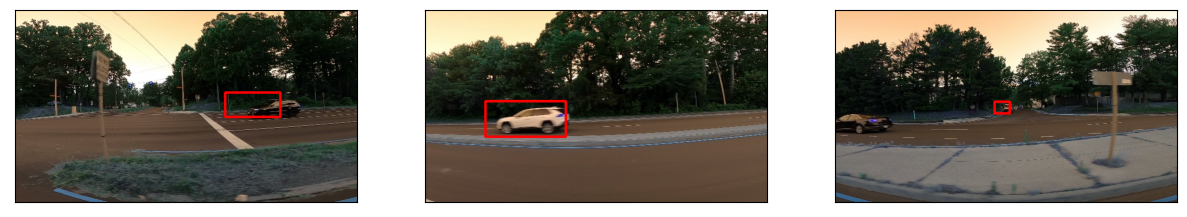

500/500 [==============================] - 2322s 5s/step - loss: 128.3468 - accuracy: 0.9866
Epoch 7/9
1/1 [==============================] - 0s 75ms/step


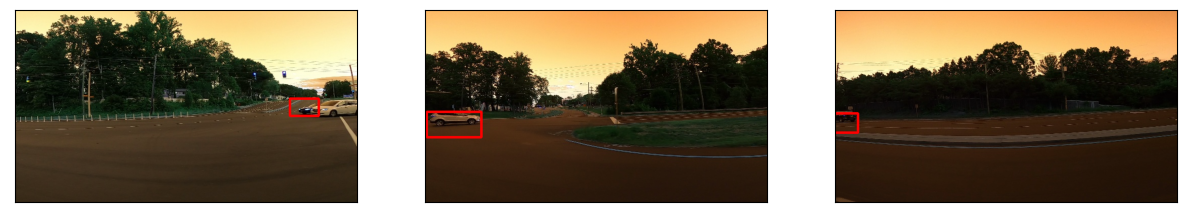

500/500 [==============================] - 3436s 7s/step - loss: 104.3921 - accuracy: 0.9912
Epoch 8/9
1/1 [==============================] - 0s 71ms/step


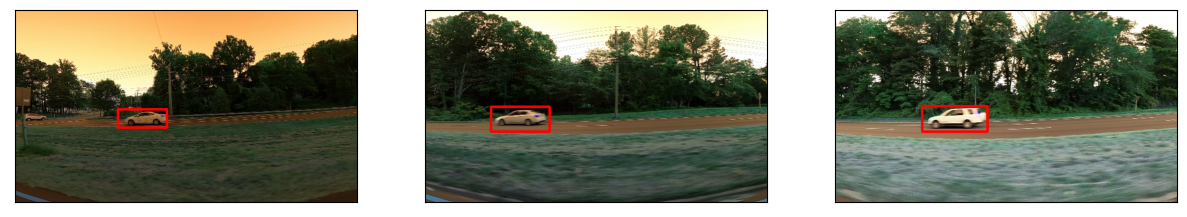

500/500 [==============================] - 3168s 6s/step - loss: 97.7206 - accuracy: 0.9898
Epoch 9/9
1/1 [==============================] - 0s 70ms/step


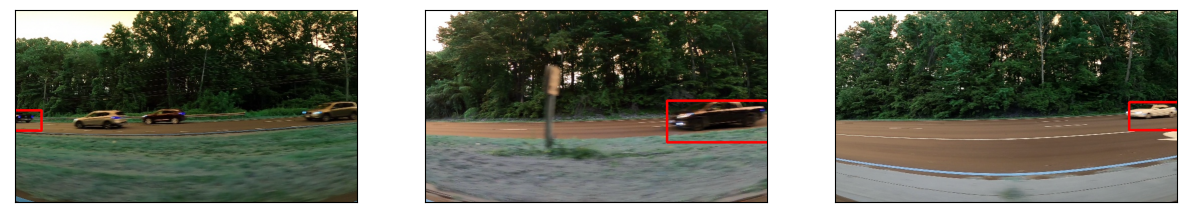

500/500 [==============================] - 3045s 6s/step - loss: 133.3673 - accuracy: 0.9885


In [277]:
history = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

Model dilatih menggunakan generator data selama 9 epoch dengan 500 langkah per epoch. Callback ShowTestImages digunakan untuk menampilkan hasil prediksi pada akhir setiap epoch

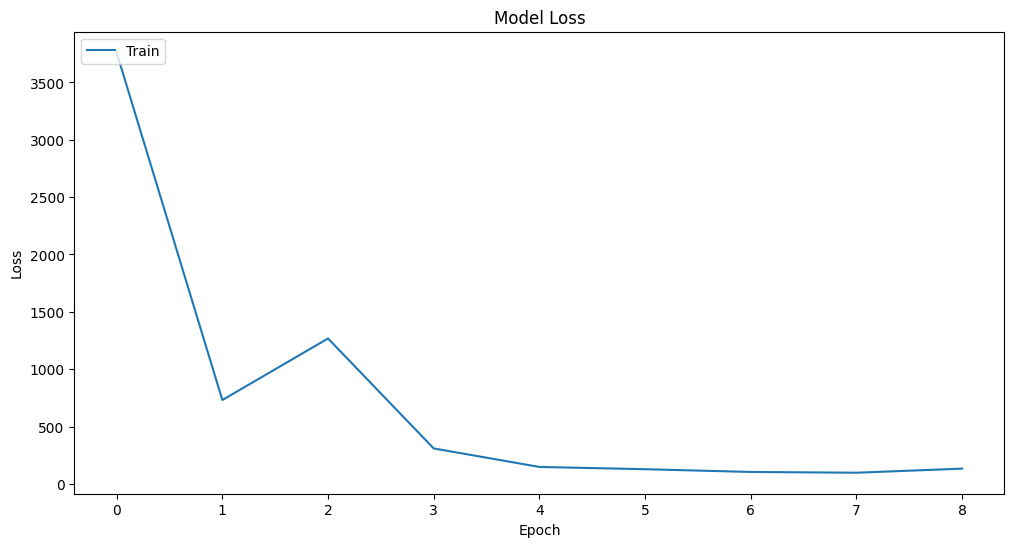

: 

In [282]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Grafik loss selama proses training